## Firsts tests with h5py and FLAMINGO data

In [1]:
import h5py
import swiftsimio as sw
import numpy as np
import matplotlib.pyplot as plt

path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    M200m = handle["SO/200_mean/TotalMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    R200m = handle["SO/200_mean/SORadius"][:] #radii, centres and positions are in Mpc
    centre = handle["InputHalos/HaloCentre"][...]


Largest 200m mass: 3.835e+15 Msol
Or 15.583751678466797 in logspace


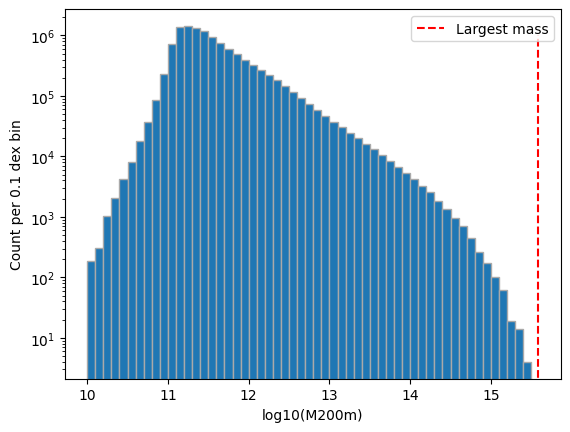

In [2]:
print(f'Largest 200m mass: {np.max(M200m):.3e} Msol')

logM200m = np.log10(M200m[M200m >= 1e10])
max_dex = np.max(logM200m)
print(f'Or {max_dex} in logspace')

fig,ax = plt.subplots()
ax.hist(logM200m,bins=np.arange(10,max_dex,0.1),log=True,edgecolor='darkgrey')
# ax.tick_params(which='both')
ax.set(xlabel = 'log10(M200m)', ylabel = 'Count per 0.1 dex bin')
ax.vlines(np.max(logM200m),0,1e6,label='Largest mass', linestyles='--', colors='red')
ax.legend()
plt.show()

In [3]:
##Example 2

path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    Mstar = handle["SO/200_mean/StellarMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    Mgas = handle["SO/200_mean/GasMass"][:]*1e10 #mass is stored in units of 1e10 solar masses

#where arg to ignore 0's
logMstar = np.log10(Mstar,where=Mstar!=0)
logMgas = np.log10(Mgas,where=Mgas!=0)
logM200m = np.log10(M200m,where=M200m!=0)

nonzero = (logMgas >= 10) * (logMstar >= 10 ) 
bar_frac = (Mgas[nonzero] + Mstar[nonzero]) / (M200m[nonzero])


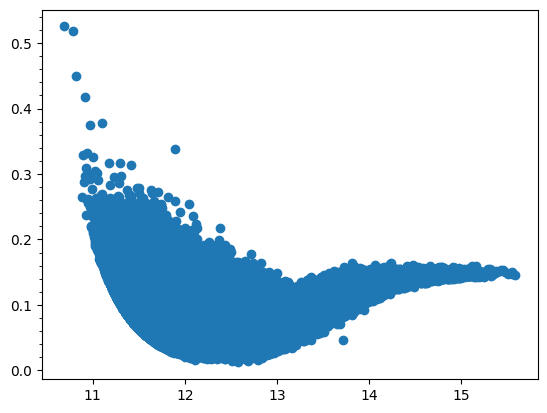

In [4]:
import matplotlib.ticker as ticker
fig,ax = plt.subplots()
ax.scatter(logM200m[nonzero], bar_frac)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.show()